# Experiments 

Paper: Facts Fade Fast: Evaluating Memorization of Outdated Medical Knowledge in Large Language Models
Reproducibility task:

Read the paper: https://arxiv.org/pdf/2509.04304

Reproduce parts of their experiments investigating when LLMs predict outdated medical knowledge using this repository: https://github.com/jvladika/MedChange

Reproducibility target: Your goal is to reproduce parts of the result in Table 2. Specifically, you **evaluate the Qwen 2.5 7B and the BioMistral 7B model** on the **Changed Knowledge Dataset**. Your task is to reproduce the precision, recall F1colums for (b) outdated Lab. and (c) Latest Labels, as well as the F1 diff colum for those two LLMs.


## Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import re
from pathlib import Path

## Set up dataframes

In [2]:
# Load the scraped studies' data and extract all DOIs from the date string
# Studies with multiple iterations have the same DOI, but end with "v2", "v3", etc.

df = pd.read_csv("./FullScraped.csv", index_col=0)
dois = [d.split("doi: ")[1].strip() if "doi: " in d else "" for d in df.date.tolist()]


In [3]:
#Load the generated questions and labels from the text fiel
with open("generated_questions_labels.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

questions = list()
labels = list()

for idx,line in enumerate(lines):
    #if idx in missing_indices:
    #    continue
    line = line.split("\n")[0]
    line = line.split(" ||| ")
    questions.append(line[0].split("QUESTION: ")[1].strip())
    labels.append(line[1].split("LABEL: ")[1].strip())
    


In [4]:
# Group the questions by DOI, so that multiple iterations of the same study are together in a group
doigroups = list()
indices = {}
for idx in range(len(dois)):
    d = dois[idx]
    if d not in indices:
        indices[d] = idx 

doisorted = sorted(dois)

# Iterate through the sorted DOIs and group them by common prefix. "Pivot" is the earliest study in the group.
idx = 0
while idx < len(dois):
    pivot = doisorted[idx]
    if pivot == "":
        idx += 1
        continue
    doigroup = list()
    while idx < len(dois) and doisorted[idx].startswith(pivot):
        doigroup.append(indices[doisorted[idx]])
        idx += 1
    doigroups.append(doigroup)

doigroups = [list(set(dg)) for dg in doigroups]
doigroups = sorted(doigroups)

def remove_duplicates(lst):
    seen = set()
    result = []
    for item in lst:
        if item not in seen:
            seen.add(item)
            result.append(item)
    return result

doigroups = [remove_duplicates(dg) for dg in doigroups]
doigroups = sorted(doigroups)

In [5]:
# Create a mapping of study iterations (by index) to their labels, for studies with multiple iterations
long_doigroups = list()
long_indices = list()
for idx,dg in enumerate(doigroups):
    if len(dg) > 1:
        long_doigroups.append(dg)
        long_indices.append(idx)

verdict_map = list()
for ld in long_doigroups:
    instance_verdicts = {}
    sorted_ld = sorted(ld)
    for idx in sorted_ld:
        instance_verdicts[idx] = labels[idx]
    verdict_map.append(instance_verdicts)

print(len(verdict_map))
#verdict_map

1535


In [19]:
## Generated answers of all models.

filenames = [#'llama33-70b_answers.txt',
 #'mistral-24b_answers.txt',
 #'gpt4o-mini_answers.txt',
 'qwen25-7b_answers.txt',
 #'deepsek-v3_answers.txt',
 #'olmo_gguf_answers_13b.txt',
 #'pmcllama_answers.txt',
 'biomistral_answers.txt', 
 #'biomistral_answers_repro.txt', 
 #'qwen_answers_repro.txt'
 #'biomistral_answers_with_refuted.txt'
 ]
filenames_repro = [
 'biomistral_answers_repro.txt', 
 'qwen_answers_repro.txt',
 'biomistral_answers_with_refuted.txt', 
 'biomistral_original_template_answers.txt', 
 'biomistral_origianl_plain_answers.txt'

 ]
filenames = ["GeneratedAnswers/"+f for f in filenames]
filenames_repro = ["GeneratedAnswers/Replicability_models/"+f for f in filenames_repro]


In [11]:
#filenames_repro.append("../HPC_results/biomistral_answers_with_refuted.txt")
for file in filenames_repro:
    print(file)


GeneratedAnswers/Replicability_models/biomistral_answers_repro.txt
GeneratedAnswers/Replicability_models/qwen_answers_repro.txt
GeneratedAnswers/Replicability_models/biomistral_answers_with_refuted_repro.txt
GeneratedAnswers/Replicability_models/biomistral_original_template_answers.txt
GeneratedAnswers/Replicability_models/biomistral_origianl_plain_answers.txt


## Get MedChangeQA results (change knowledge subset)

In [12]:
## Get all the labels of MedChangeQA

final_labels = list()
final_keys = list()
outdated_keys = list()
outdated_labels = list()  
newest_labels = list()   
newest_keys = list()

for verdict_dict in verdict_map:
    final_label = verdict_dict[list(verdict_dict.keys())[0]]
    final_labels.append(final_label)
    final_keys.append(list(verdict_dict.keys())[0])

    verdict_changed = False
    for key in verdict_dict.keys():
        if verdict_dict[key] != final_label:

            outdated_keys.append(key)
            outdated_labels.append(verdict_dict[key])

            newest_labels.append(verdict_dict[list(verdict_dict.keys())[0]])
            newest_keys.append(list(verdict_dict.keys())[0])

            verdict_changed = True
            break

# MedChangeQA is a subset where 512 questions changed their verdict over time
len(final_labels), len(newest_labels) 

(1535, 512)

In [29]:

## Get final evaluation scores of the predicted LLM answers

def get_predictions_change_knowledge(filename, label_type, old=True):
    with open(filename, "r", encoding="utf-8") as f:
        lines = f.readlines()
        #print('open')
        
    if ("biomistral" in filename or "pmcllama" in filename)and old is True:
        #print("biomistral or pcmllama")
        lines = lines[1::3]
    
    # Get all the predicted labels on the entire dataset MedRevQA
    llm_predicted_labels = list()
    tokens_supported = ("SUPPORTED", "Supported:", "EFFECTIVE",
                        ": Supported","(supported)", "(Supported)", "Effective:",
                         ": YES", "YES:", "POSITIVE", "(YES)", "SUPPORTed")
    
    tokens_nei =("NOT ENOUGH INFORMATION:", "NOT ENOUGH INFORMATION", "NOT_ENOUGH_INFORMATION",
                "Not Enough Information:", "Not enough information." )


    for line in lines:
        #line = re.sub(r'[^\w\s]','',line_notnorm).strip()
        
        if "REFUTED" in line or "REF UTED" in line:
            llm_predicted_labels.append("REFUTED")
        elif any(tok in line for tok in tokens_nei):
            llm_predicted_labels.append("NOT ENOUGH INFORMATION")
        elif any(tok in line for tok in tokens_supported):
            llm_predicted_labels.append("SUPPORTED")
        else:
            llm_predicted_labels.append("NO LABEL FOUND")
            #print(line)
            #print(line_notnorm)
            #print('.....')
        
    #print(f'len llm predicted labels: {len(llm_predicted_labels)}')
    #print(f'len "NO LABEL FOUND": {llm_predicted_labels.count('NO LABEL FOUND')}')
    print(f'REFUTED: {llm_predicted_labels.count("REFUTED")}')
    print(f'NOT ENOUGH INFORMATION: {llm_predicted_labels.count("NOT ENOUGH INFORMATION")}')
    print(f'SUPPORTED: {llm_predicted_labels.count("SUPPORTED")}')


    # Get only the changed-knowledge subset (MedChangeQA)
    #llm_predicted_medchange = np.array(llm_predicted_labels)[np.array(outdated_keys)]
    #llm_predicted_medchange = np.array(llm_predicted_labels, dtype=object)[np.array(outdated_keys, dtype=int)]

    mapper = {"SUPPORTED": 0, "REFUTED": 2, "NOT ENOUGH INFORMATION": 1}
        
    pred_all = np.array(llm_predicted_labels, dtype=object)[np.array(outdated_keys, dtype=int)]

    gold_all = np.array([mapper[g] for g in (outdated_labels if label_type=="OUTDATED" else newest_labels)], dtype=int)

    #print(f'len(pred_all): {len(pred_all)}')
    #print(f'len(gold_all): {len(gold_all)}')


    common_len = min(len(pred_all), len(gold_all))
    if len(pred_all) != len(gold_all):
        print(f"[LENGTH MISMATCH] pred={len(pred_all)} vs gold={len(gold_all)} → {common_len}")
    pred_slice = pred_all[:common_len]
    gold_slice = gold_all[:common_len]

    #  Mask  (discart 'NO LABEL FOUND')
    mask = (pred_slice != "NO LABEL FOUND")
    dropped = int((~mask).sum())
    if dropped:
        masked_pos = np.flatnonzero(~mask)

        subset_keys = np.array(outdated_keys, dtype=int)[:common_len]
        masked_items = subset_keys[masked_pos]

        is_triplet_used = ("biomistral" in filename) or ("pmcllama" in filename)

        print(f"[NO LABEL FOUND] {dropped} points masked. Showing up to 50:")
        for i, pos in enumerate(masked_pos[:50], start=1):
            item_idx = int(masked_items[i-1])  
            if 0 <= item_idx < len(lines):
                preview = lines[item_idx].rstrip("\n")
            else:
                preview = "<out of range in current 'lines' view>"

            if is_triplet_used:
                file_line = item_idx * 3 + 2  
            else:
                file_line = item_idx + 1

            if len(preview) > 220:
                preview = preview[:220] + "…"
            print(f"  - subset_pos={int(pos)} | item_idx={item_idx} | file_line={file_line} | {preview}")

    
    y_test = gold_slice[mask]    
    y_pred = np.array([mapper[p] for p in pred_slice[mask]], dtype=int)

    # Calculate precision, recall, and F1 score with macro averaging
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    classes = np.unique(y_test)
    present = np.unique(y_pred)
    missing_preds = set(classes) - set(present)
    if missing_preds:
        print("[INFO] No info for classes:", missing_preds)

    ## get precision, recall, f1, accuracy rounded to 4 decimal places

    print(f"Precision: {precision_macro:.4f} | Recall: {recall_macro:.4f} | F1: {f1_macro:.4f}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    #WE ADDED THIS RETURN 
    return precision_macro,recall_macro, f1_macro


In [38]:
metrics = ['model', 'P_outdated', 'R_outdated', 'F1_outdated', 'P_latest', 'R_latest', 'F1_latest', 'F1_diff' ]
df = pd.DataFrame(columns=metrics)

In [39]:

summary_rows = []
print('ORIGINAL PAPER RESULTS')
for file in filenames: 
    pat = re.compile(r'([^/\\]+)\.txt$', re.IGNORECASE)
    name_re = pat.search(file).group(1) 
    print('-----')
    print(file)
    print('-----')
    print(" Latest")
    p_latest, r_latest, f1_latest = get_predictions_change_knowledge(file, label_type='NEWEST', old=True)
    print(" Outdated")
    p_outdated, r_outdated, f1_outdated = get_predictions_change_knowledge(file, label_type='OUTDATED', old=True)
    print('')
    f1_diff = (f1_latest - f1_outdated)*100
    print(f"F1 diff: {f1_diff}")
    print('')

    df.loc[len(df)] = {
        'model':      name_re,
        'P_outdated': round(p_outdated * 100, 1),
        'R_outdated': round(r_outdated * 100, 1),
        'F1_outdated': round(f1_outdated * 100, 1),
        'P_latest':   round(p_latest * 100, 1),
        'R_latest':   round(r_latest * 100, 1),
        'F1_latest':  round(f1_latest * 100, 1),
        'F1_diff':    round(f1_diff, 1)
    }

    original_diff = f1_diff
    
    print(file.split("/")[-1][:4])
    # save partial results
    summary_rows.append({
        "file": file.split("/")[-1][:4],
        "orig_latest": round(f1_latest*100,1),
        "orig_outdated": round(f1_outdated*100,1),
        "orig_diff": round(original_diff,1),
        "our_latest": None,
        "our_outdated": None,
        "our_diff": None
    })
    



ORIGINAL PAPER RESULTS
-----
GeneratedAnswers/qwen25-7b_answers.txt
-----
 Latest
REFUTED: 2213
NOT ENOUGH INFORMATION: 2261
SUPPORTED: 12027
Precision: 0.2712 | Recall: 0.3082 | F1: 0.2602
Accuracy: 0.3730
 Outdated
REFUTED: 2213
NOT ENOUGH INFORMATION: 2261
SUPPORTED: 12027
Precision: 0.4262 | Recall: 0.3711 | F1: 0.3076
Accuracy: 0.3535

F1 diff: -4.739933696312237

qwen
-----
GeneratedAnswers/biomistral_answers.txt
-----
 Latest
REFUTED: 4605
NOT ENOUGH INFORMATION: 5078
SUPPORTED: 6073
[NO LABEL FOUND] 20 points masked. Showing up to 50:
  - subset_pos=41 | item_idx=8141 | file_line=24425 | Answer: 1. Instrumental dysphagia (swallowing of solids) |||             2. Oral dysphagia (swallowing of liquids) |||             3. Nutritional support (enteral feeding) |||             INITIAL STATEMENT: All of the ab…
  - subset_pos=78 | item_idx=4512 | file_line=13538 | Answer: 1. Intravenous gadolinium-based contrast agents (GBCAs) in patients with advanced renal insufficiency.
  - subset

In [40]:
print('OUR MODEL RESULTS')
for file in filenames_repro: 
    pat = re.compile(r'([^/\\]+)\.txt$', re.IGNORECASE)
    name_re = pat.search(file).group(1) 
    print('-----')
    print(file)
    print('-----')
    print(" Latest")
    p_latest, r_latest, f1_latest = get_predictions_change_knowledge(file, label_type='NEWEST', old=False)
    print(" Outdated")
    p_outdated, r_outdated, f1_outdated = get_predictions_change_knowledge(file, label_type='OUTDATED', old=False)
    print('')
    f1_diff = (f1_latest - f1_outdated)*100
    print(f"F1 diff: {f1_diff}")
    print('')

    df.loc[len(df)] = {
        'model':      name_re,
        'P_outdated': round(p_outdated * 100, 1),
        'R_outdated': round(r_outdated * 100, 1),
        'F1_outdated': round(f1_outdated * 100, 1),
        'P_latest':   round(p_latest * 100, 1),
        'R_latest':   round(r_latest * 100, 1),
        'F1_latest':  round(f1_latest * 100, 1),
        'F1_diff':    round(f1_diff, 1)
    }


    

    our_diff = f1_diff


    print( file.split("/")[-1][:4])
    # find matching original row (same file)
    for row in summary_rows:
        if row["file"] == file.split("/")[-1][:4]:
            row["our_latest"] = round(f1_latest*100,1)
            row["our_outdated"] = round(f1_outdated*100,1)
            row["our_diff"] = round(our_diff,1)
            break
    

OUR MODEL RESULTS
-----
GeneratedAnswers/Replicability_models/biomistral_answers_repro.txt
-----
 Latest
REFUTED: 0
NOT ENOUGH INFORMATION: 14391
SUPPORTED: 2110
[INFO] No info for classes: {2}
Precision: 0.2707 | Recall: 0.3359 | F1: 0.2363
Accuracy: 0.3359
 Outdated
REFUTED: 0
NOT ENOUGH INFORMATION: 14391
SUPPORTED: 2110
[INFO] No info for classes: {2}
Precision: 0.2587 | Recall: 0.3367 | F1: 0.2703
Accuracy: 0.4414

F1 diff: -3.399789103922485

biom
-----
GeneratedAnswers/Replicability_models/qwen_answers_repro.txt
-----
 Latest
REFUTED: 453
NOT ENOUGH INFORMATION: 4433
SUPPORTED: 11613
Precision: 0.3355 | Recall: 0.3133 | F1: 0.2681
Accuracy: 0.3789
 Outdated
REFUTED: 453
NOT ENOUGH INFORMATION: 4433
SUPPORTED: 11613
Precision: 0.3982 | Recall: 0.3803 | F1: 0.3092
Accuracy: 0.3887

F1 diff: -4.1095515898888655

qwen
-----
GeneratedAnswers/Replicability_models/biomistral_answers_with_refuted.txt
-----
 Latest
REFUTED: 141
NOT ENOUGH INFORMATION: 11666
SUPPORTED: 4644
[NO LABEL FOUN

In [42]:
df = df.sort_values(by='model')
df

,model,P_outdated,R_outdated,F1_outdated,P_latest,R_latest,F1_latest,F1_diff
1,biomistral_answers,34.5,35.3,34.1,35.7,35.9,35.7,1.7
2,biomistral_answers_repro,25.9,33.7,27.0,27.1,33.6,23.6,-3.4
4,biomistral_answers_with_refuted,61.0,36.3,31.7,26.3,33.9,26.6,-5.1
6,biomistral_origianl_plain_answers,38.1,36.4,32.5,38.6,33.6,27.7,-4.8
5,biomistral_original_template_answers,27.7,35.5,29.8,26.0,33.5,24.8,-5.0
0,qwen25-7b_answers,42.6,37.1,30.8,27.1,30.8,26.0,-4.7
3,qwen_answers_repro,39.8,38.0,30.9,33.5,31.3,26.8,-4.1


In [43]:
df_summary = pd.DataFrame(summary_rows)

print("\nSUMMARY TABLE")
df_summary




SUMMARY TABLE


,file,orig_latest,orig_outdated,orig_diff,our_latest,our_outdated,our_diff
0,qwen,26.0,30.8,-4.7,26.8,30.9,-4.1
1,biom,35.7,34.1,1.7,27.7,32.5,-4.8


## Exploratory Analysis

First we are going to upload all the dfs that we want to use

In [6]:

question_label_path = "generated_questions_labels.txt"

rows = []
with open(question_label_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue 
        
        parts = [p.strip() for p in line.split("|||")]
        
        if len(parts) != 3:
            print("Línea con formato inesperado:", line)
            continue
        
        q = parts[0].replace("QUESTION:", "").strip()
        label = parts[1].replace("LABEL:", "").strip()
        level = parts[2].replace("LEVEL:", "").strip()
        
        rows.append({"question": q, "label": label, "level": level})

df_question_labels = pd.DataFrame(rows)

df_question_labels.head()


,question,label,level
0,Does transjugular intrahepatic portosystemic s...,NOT ENOUGH INFORMATION,LOW
1,Do non-pharmacological interventions help redu...,SUPPORTED,MEDIUM
2,Is tranexamic acid effective in reducing blood...,SUPPORTED,MEDIUM
3,Are off-midline wound closure methods more eff...,SUPPORTED,LOW
4,Does testosterone replacement therapy improve ...,REFUTED,MEDIUM


In [17]:
df_question_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16501 entries, 0 to 16500
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  16501 non-null  object
 1   label     16501 non-null  object
 2   level     16501 non-null  object
dtypes: object(3)
memory usage: 386.9+ KB


In [ ]:
medchangeQA_path = "../Datasets/MedChangeQA.csv"
df_medChange = pd.read_csv(medchangeQA_path)
df_medChange.head()


,Unnamed: 0,Question,Newest Label,Outdated Label
0,1,Is cranberry juice effective for treating urin...,SUPPORTED,REFUTED
1,2,Is add-on lamotrigine effective in reducing se...,SUPPORTED,NOT ENOUGH INFORMATION
2,3,Do statins help reduce cardiovascular events i...,SUPPORTED,NOT ENOUGH INFORMATION
3,4,Do antibiotics effectively reduce pain in chil...,SUPPORTED,NOT ENOUGH INFORMATION
4,8,Does cell salvage reduce the need for blood tr...,REFUTED,NOT ENOUGH INFORMATION


In [18]:
df_medChange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      512 non-null    int64 
 1   Question        512 non-null    object
 2   Newest Label    512 non-null    object
 3   Outdated Label  512 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.1+ KB


In [16]:
og_biomistral_path = "GeneratedAnswers/biomistral_answers.txt"

with open(og_biomistral_path, "r", encoding="utf-8") as f:
    text = f.read()

blocks = [b.strip() for b in text.split('---') if b.strip()]

rows = []

tokens_supported = (
    "SUPPORTED", "Supported:", "EFFECTIVE",
    ": Supported", "(supported)", "(Supported)", "Effective:",
    ": YES", "YES:", "POSITIVE", "(YES)", "SUPPORTed"
)

tokens_nei = (
    "NOT ENOUGH INFORMATION:", "NOT ENOUGH INFORMATION",
    "NOT_ENOUGH_INFORMATION", "Not Enough Information:",
    "Not enough information."
)

for block in blocks:
    q_match = re.search(r"Question:\s*(.+)", block)
    if not q_match:
        continue
    question = q_match.group(1).strip()

    ans_split = block.split("Answer:", 1)
    if len(ans_split) < 2:
        continue
    answer_part = ans_split[1]

    label = None
    if "REFUTED" in answer_part or "REF UTED" in answer_part:
        label = "REFUTED"
    elif any(tok in answer_part for tok in tokens_nei):
        label = "NOT ENOUGH INFORMATION"
    
    elif any(tok in answer_part for tok in tokens_supported):
        label = "SUPPORTED"

    rows.append({"Question": question, "label": label})

df_og_biomistral = pd.DataFrame(rows)

df_og_biomistral.head()


,Question,label
0,Does transjugular intrahepatic portosystemic s...,None
1,Do non-pharmacological interventions help redu...,NOT ENOUGH INFORMATION
2,Is tranexamic acid effective in reducing blood...,SUPPORTED
3,Are off-midline wound closure methods more eff...,NOT ENOUGH INFORMATION
4,Does testosterone replacement therapy improve ...,SUPPORTED


In [14]:
df_og_biomistral.info()
print(f'No label in {16501-15756} labels from df_og_biomistral')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16501 entries, 0 to 16500
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Question  16501 non-null  object
 1   label     15756 non-null  object
dtypes: object(2)
memory usage: 258.0+ KB
No label in 745 labels from df_og_biomistral


In [ ]:
re_biomistral_path = "GeneratedAnswers/Replicability_models/biomistral_origianl_plain_answers.txt"

df_re_biomistral = df_question_labels[["question"]].copy()

labels = []

tokens_supported = (
    "SUPPORTED", "Supported:", "EFFECTIVE",
    ": Supported", "(supported)", "(Supported)", "Effective:",
    ": YES", "YES:", "POSITIVE", "(YES)", "SUPPORTed"
)

tokens_nei = (
    "NOT ENOUGH INFORMATION:", "NOT ENOUGH INFORMATION",
    "NOT_ENOUGH_INFORMATION", "Not Enough Information:",
    "Not enough information."
)

with open(re_biomistral_path, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  

        label = None
        if "REFUTED" in line or "REF UTED" in line:
            label = "REFUTED"
        elif any(tok in line for tok in tokens_nei):
            label = "NOT ENOUGH INFORMATION"
        elif any(tok in line for tok in tokens_supported):
            label = "SUPPORTED"

        labels.append(label)


#print(len(labels), len(df_re_biomistral))

df_re_biomistral["label"] = labels
df_re_biomistral.head()


,question,label
0,Does transjugular intrahepatic portosystemic s...,NOT ENOUGH INFORMATION
1,Do non-pharmacological interventions help redu...,NOT ENOUGH INFORMATION
2,Is tranexamic acid effective in reducing blood...,SUPPORTED
3,Are off-midline wound closure methods more eff...,NOT ENOUGH INFORMATION
4,Does testosterone replacement therapy improve ...,SUPPORTED


In [27]:
df_re_biomistral.info()
print(f'No label in {16501-16326} labels from df_re_biomistral')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16501 entries, 0 to 16500
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  16501 non-null  object
 1   label     16326 non-null  object
dtypes: object(2)
memory usage: 258.0+ KB
No label in 175 labels from df_re_biomistral


### Results: biomistral. 

First we are going to compare the labels that they did got vs the ones that we got. In order to do that we are using a sankey plot. 
1. Remove duplicates
2. Create a df
3. Plot Sankey Plots

In [61]:

df_og = df_og_biomistral.rename(columns={
    "Question": "question",   
    "label": "label_og"        
}).drop_duplicates(subset=["question"])

df_re = df_re_biomistral.rename(columns={
    "label": "label_re"       
}).drop_duplicates(subset=["question"])

df_change = df_medChange.rename(columns={
    "Question": "question"      
}).drop_duplicates(subset=['question']).drop(columns=["Unnamed: 0"])

df_re_og = pd.merge(df_og, df_re, on="question", how="inner")
df_merged = pd.merge(df_re_og, df_change, on="question", how="inner")


In [55]:
df_re_og.info()
df_re_og.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13459 entries, 0 to 13458
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  13459 non-null  object
 1   label_og  12962 non-null  object
 2   label_re  13314 non-null  object
dtypes: object(3)
memory usage: 315.6+ KB


,question,label_og,label_re
0,Does transjugular intrahepatic portosystemic s...,None,NOT ENOUGH INFORMATION
1,Do non-pharmacological interventions help redu...,NOT ENOUGH INFORMATION,NOT ENOUGH INFORMATION
2,Is tranexamic acid effective in reducing blood...,SUPPORTED,SUPPORTED
3,Are off-midline wound closure methods more eff...,NOT ENOUGH INFORMATION,NOT ENOUGH INFORMATION
4,Does testosterone replacement therapy improve ...,SUPPORTED,SUPPORTED


In [56]:
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question        502 non-null    object
 1   label_og        481 non-null    object
 2   label_re        500 non-null    object
 3   Newest Label    502 non-null    object
 4   Outdated Label  502 non-null    object
dtypes: object(5)
memory usage: 19.7+ KB


,question,label_og,label_re,Newest Label,Outdated Label
0,Is cranberry juice effective for treating urin...,REFUTED,REFUTED,SUPPORTED,REFUTED
1,Is add-on lamotrigine effective in reducing se...,SUPPORTED,SUPPORTED,SUPPORTED,NOT ENOUGH INFORMATION
2,Do statins help reduce cardiovascular events i...,SUPPORTED,SUPPORTED,SUPPORTED,NOT ENOUGH INFORMATION
3,Do antibiotics effectively reduce pain in chil...,REFUTED,NOT ENOUGH INFORMATION,SUPPORTED,NOT ENOUGH INFORMATION
4,Does cell salvage reduce the need for blood tr...,NOT ENOUGH INFORMATION,SUPPORTED,REFUTED,NOT ENOUGH INFORMATION


In [71]:

import plotly.graph_objects as go

df = df_re_og.copy()

df["label_og"] = (df["label_og"].fillna("NO LABEL").replace({"None": "NO LABEL"}))

df["label_re"] = (df["label_re"].fillna("NO LABEL").replace({"None": "NO LABEL"}))

df["node_og"] = "OG: " + df["label_og"]
df["node_re"] = "RE: " + df["label_re"]

flows = (df.groupby(["node_og", "node_re"]).size().reset_index(name="count"))

nodes_og = sorted(df["node_og"].unique())
nodes_re = sorted(df["node_re"].unique())
labels = nodes_og + nodes_re

color_map = {
    "OG: SUPPORTED": "#4CAF50",                 
    "OG: REFUTED": "#F44336",                   
    "OG: NOT ENOUGH INFORMATION": "#FFC107",    
    "OG: NO LABEL": "#9E9E9E",         
    "RE: SUPPORTED": "#4CAF50",                 
    "RE: REFUTED": "#F44336",                   
    "RE: NOT ENOUGH INFORMATION": "#FFC107",    
    "RE: NO LABEL": "#9E9E9E",             
}

label_to_idx = {lab: i for i, lab in enumerate(labels)}

source = flows["node_og"].map(label_to_idx)
target = flows["node_re"].map(label_to_idx)
value  = flows["count"]

node_colors = [color_map[node]for node in labels]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=20,thickness=20,label=labels, color=node_colors),
    link=dict(source=source,target=target,value=value))])

fig.update_layout(
    title_text="ALL QUESTIONS (original paper (OG) → reproducibility(RE))",
    font_size=12
)

fig.show()


we observe a clear drift of labels toward the NOT ENOUGH INFORMATION category after re-prompting. 
Questions originally classified as REFUTED are reassigned to NOT ENOUGH INFORMATION in the reproducibility setting. This shift reflects a more cautious behavior of the model—opting  uncertainty rather than a negative claim. 

This has an impact on the F1-score diff

#### MedChange

In [93]:
df = df_merged.copy() 

df["Newest Label"]   = df["Newest Label"].fillna("NO LABEL").replace({"None": "NO LABEL"})
df["Outdated Label"] = df["Outdated Label"].fillna("NO LABEL").replace({"None": "NO LABEL"})

df["node_new"] = "NEW: " + df["Newest Label"]
df["node_old"] = "OLD: " + df["Outdated Label"]

flows = (df.groupby(["node_new", "node_old"]).size().reset_index(name="count"))

nodes_new = sorted(df["node_new"].unique())
nodes_old = sorted(df["node_old"].unique())
labels = nodes_old + nodes_new

color_map = {
    "NEW: SUPPORTED": "#4CAF50",
    "NEW: REFUTED": "#F44336",
    "NEW: NOT ENOUGH INFORMATION": "#FFC107",
    "NEW: NO LABEL": "#9E9E9E",
    "OLD: SUPPORTED": "#4CAF50",
    "OLD: REFUTED": "#F44336",
    "OLD: NOT ENOUGH INFORMATION": "#FFC107",
    "OLD: NO LABEL": "#9E9E9E",
}

label_to_idx = {lab: i for i, lab in enumerate(labels)}

target = flows["node_new"].map(label_to_idx)
source = flows["node_old"].map(label_to_idx)
value  = flows["count"]

node_colors = [color_map.get(lab, "#CCCCCC") for lab in labels]

fig = go.Figure(data=[go.Sankey(
    node=dict(pad=20,thickness=20,label=labels, color=node_colors),
    link=dict(source=source,target=target,value=value))])

fig.update_layout(
    title_text="Flow from  OUTDATED LABEL → NEWEST LABEL  (MedChangeQA)",
    font_size=12
)

fig.show()


In [79]:
df = df_merged.copy() 
print('BIOMISTRAL')
same_new = (df["label_og"] == df["Newest Label"]).mean()
same_old = (df["label_og"] == df["Outdated Label"]).mean()
print('---ORIGINAL PAPER-------')
print(f"Agreement with NEWEST:  {same_new:.3f}")
print(f"Agreement with OUTDATED:{same_old:.3f}")

same_new = (df["label_re"] == df["Newest Label"]).mean()
same_old = (df["label_re"] == df["Outdated Label"]).mean()
print('---REPRODUCIABLITY-------')
print(f"Agreement with NEWEST:  {same_new:.3f}")
print(f"Agreement with OUTDATED:{same_old:.3f}")




BIOMISTRAL
---ORIGINAL PAPER-------
Agreement with NEWEST:  0.319
Agreement with OUTDATED:0.349
---REPRODUCIABLITY-------
Agreement with NEWEST:  0.319
Agreement with OUTDATED:0.420


In [80]:

for col in ["label_re", "Newest Label", "Outdated Label"]:
    df[col] = df[col].fillna("NO LABEL").replace({"None": "NO LABEL"})

df["node_old"] = "OLD: " + df["Outdated Label"]
df["node_re"]  = "RE: "  + df["label_re"]
df["node_new"] = "NEW: " + df["Newest Label"]

flows_old_re = (
    df.groupby(["node_old", "node_re"])
      .size()
      .reset_index(name="count")
)

flows_re_new = (
    df.groupby(["node_re", "node_new"])
      .size()
      .reset_index(name="count")
)

nodes_old = sorted(df["node_old"].unique())
nodes_re  = sorted(df["node_re"].unique())
nodes_new = sorted(df["node_new"].unique())
labels = nodes_old + nodes_re + nodes_new

label_to_idx = {lab: i for i, lab in enumerate(labels)}

sources = []
targets = []
values  = []

# OLD → RE
sources.extend(flows_old_re["node_old"].map(label_to_idx))
targets.extend(flows_old_re["node_re"].map(label_to_idx))
values.extend(flows_old_re["count"])

# RE → NEW
sources.extend(flows_re_new["node_re"].map(label_to_idx))
targets.extend(flows_re_new["node_new"].map(label_to_idx))
values.extend(flows_re_new["count"])

color_map = {
    "SUPPORTED": "#4CAF50",
    "REFUTED": "#F44336",
    "NOT ENOUGH INFORMATION": "#FFC107",
    "NO LABEL": "#9E9E9E",
}

def base_label(node_name):
    return node_name.split(": ", 1)[1]

node_colors = [color_map.get(base_label(l), "#CCCCCC") for l in labels]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=20,
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title_text="Flow from OUTDATED → RE (model) → NEWEST labels", font_size=12
)

fig.show()


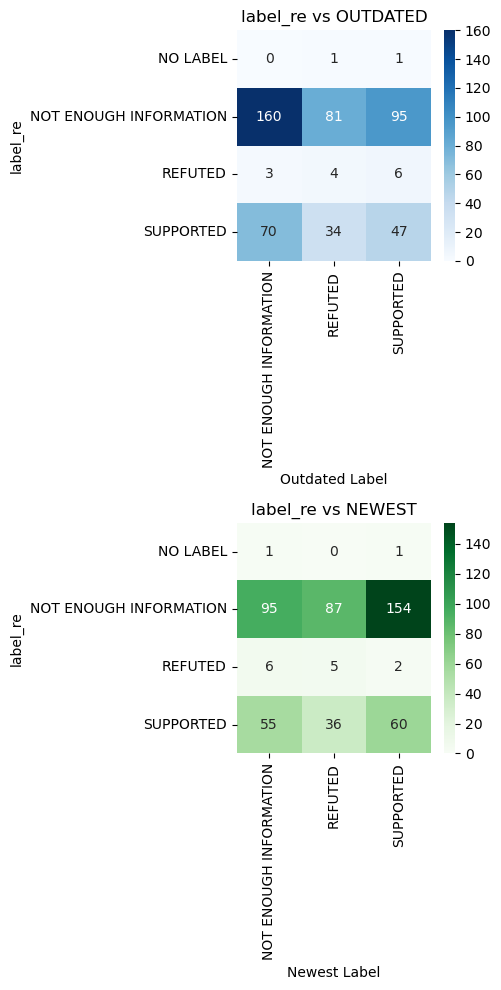

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_merged.copy()

for col in ["label_re", "Newest Label", "Outdated Label"]:
    df[col] = df[col].fillna("NO LABEL").replace({"None": "NO LABEL"})

cm_old = pd.crosstab(df["label_re"], df["Outdated Label"])
cm_new = pd.crosstab(df["label_re"], df["Newest Label"])

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

sns.heatmap(cm_old, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("label_re vs OUTDATED")

sns.heatmap(cm_new, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("label_re vs NEWEST")

plt.tight_layout()
plt.show()


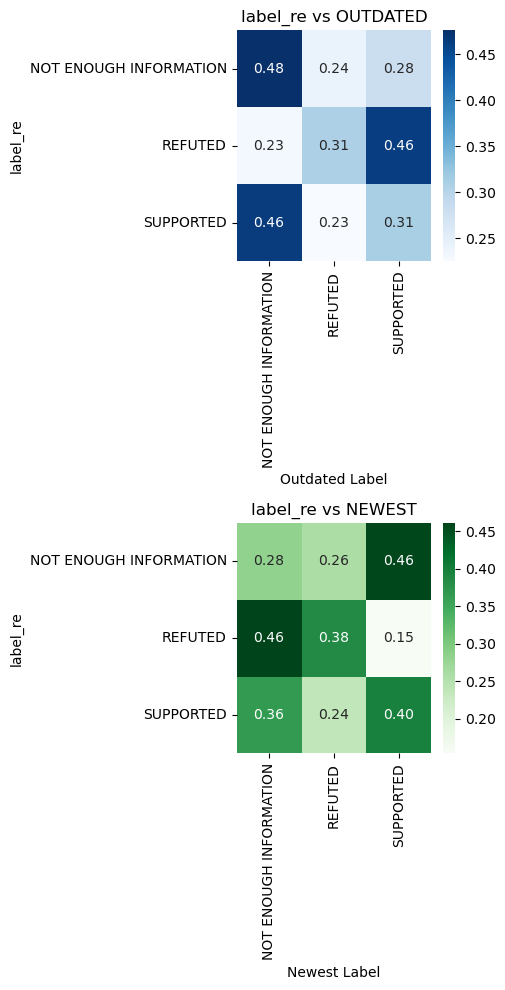

In [92]:

for col in ["label_re", "Newest Label", "Outdated Label"]:
    df[col] = df[col].fillna("NO LABEL").replace({"None": "NO LABEL"})

cm_old = pd.crosstab(df["label_re"], df["Outdated Label"])
cm_new = pd.crosstab(df["label_re"], df["Newest Label"])
cm_old = cm_old.drop(index="NO LABEL", columns=["NO LABEL"], errors="ignore")
cm_new = cm_new.drop(index="NO LABEL", columns=["NO LABEL"], errors="ignore")


cm_old_norm = cm_old.div(cm_old.sum(axis=1), axis=0)
cm_new_norm = cm_new.div(cm_new.sum(axis=1), axis=0)

fig, axes = plt.subplots(2, 1, figsize=(5, 10))

sns.heatmap(cm_old_norm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("label_re vs OUTDATED")

sns.heatmap(cm_new_norm, annot=True, fmt=".2f", cmap="Greens", ax=axes[1])
axes[1].set_title("label_re vs NEWEST")

plt.tight_layout()
plt.show()
